### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on Secrets (🔑). Store Roboflow API Key under the name ROBOFLOW_API_KEY.

In [7]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

In [8]:
!nvidia-smi

Sun Dec 21 20:50:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [10]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 135.7 MB/s eta 0:00:00


## Download dataset from Roboflow Universe

In [11]:
from roboflow import Roboflow
rf = Roboflow(api_key=API_KEY)
project = rf.workspace("thesis-digkz").project("ball-detection-bzirz")
version = project.version(2)
dataset = version.download("yolov12")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ball-detection-2 in yolov12:: 100%|██████████| 718/718 [00:00<00:00, 8424.89it/s]


In [12]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [13]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [14]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['cue ball', 'other']

roboflow:
  workspace: thesis-digkz
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [15]:
from ultralytics import YOLO

model = YOLO('yolov12n.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=150, batch=16, imgsz=640, patience=30)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.240 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12n.yaml, data=/content/ball-detection-2/data.yaml, epochs=150, time=None, patience=30, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, 

100%|██████████| 755k/755k [00:00<00:00, 23.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      2368  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2, 1, 2]          
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2, 1, 4]          
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    174720  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 105MB/s]


AMP: checks passed ✅


train: Scanning /content/ball-detection-2/train/labels... 309 images, 0 backgrounds, 0 corrupt: 100%|██████████| 309/309 [00:00<00:00, 1828.47it/s]

train: New cache created: /content/ball-detection-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/ball-detection-2/valid/labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 1006.23it/s]

val: New cache created: /content/ball-detection-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      3.83G      5.749      4.939      4.452         41        640: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.26s/it]

                   all         29        212          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      3.81G      4.959      4.172      4.024         67        640: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         29        212          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      3.82G      4.015      3.276      3.202         52        640: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         29        212          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      3.81G      3.292      2.757       2.69         33        640: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         29        212          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      3.81G      2.834      2.328      2.353        101        640: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         29        212     0.0101      0.623     0.0332     0.0145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      3.83G      2.502      2.015      2.022         81        640: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         29        212     0.0179     0.0555     0.0198    0.00703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      3.81G      2.355      1.803       1.95         71        640: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         29        212   0.000786    0.00273   0.000404   8.08e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      3.83G      2.246      1.666      1.844         61        640: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         29        212      0.552      0.337      0.383      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      3.83G      2.132       1.54      1.732         70        640: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         29        212      0.503      0.577      0.642      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      3.81G      2.146      1.533      1.705         33        640: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         29        212      0.579      0.552       0.58      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      3.83G      2.061      1.467      1.658         94        640: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         29        212      0.843      0.833      0.908       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      3.82G      1.998      1.347      1.588         41        640: 100%|██████████| 20/20 [00:06<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         29        212      0.849      0.872      0.934      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      3.78G      1.938      1.309      1.573         76        640: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         29        212      0.871      0.868      0.934      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      3.76G      1.883      1.283      1.512         51        640: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         29        212      0.952      0.863      0.955      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      3.76G      1.872       1.24      1.495         26        640: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         29        212      0.922      0.879      0.957      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      3.82G      1.836      1.214      1.512         75        640: 100%|██████████| 20/20 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         29        212      0.913      0.884      0.965      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      3.83G        1.8      1.184      1.501         51        640: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         29        212      0.963      0.806      0.937      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      3.82G      1.801      1.139      1.441         42        640: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         29        212      0.934      0.835       0.95      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      3.81G      1.747      1.133      1.463         39        640: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         29        212      0.897      0.905      0.956      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      3.81G      1.775      1.123      1.455         71        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         29        212      0.897      0.886      0.946      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      3.81G      1.716      1.055      1.401         62        640: 100%|██████████| 20/20 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         29        212      0.979      0.932      0.983      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      3.82G      1.765      1.082      1.404         59        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         29        212       0.89      0.846      0.942      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      3.83G      1.737      1.079      1.416         57        640: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         29        212      0.967      0.939      0.984      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      3.83G      1.699      1.062      1.384         53        640: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         29        212      0.968      0.945      0.987      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      3.82G       1.67      1.047      1.386         79        640: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         29        212      0.951      0.829      0.963      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      3.83G      1.695      1.008      1.373         86        640: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29        212       0.93      0.965      0.986      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      3.82G       1.69      1.011      1.373         67        640: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         29        212      0.917      0.954      0.976      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      3.84G      1.702      1.023       1.39         84        640: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         29        212      0.949      0.855      0.944      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      3.79G      1.618     0.9841      1.308         53        640: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         29        212      0.961      0.954      0.987      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      3.77G      1.619     0.9674      1.341         51        640: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         29        212      0.912      0.833      0.946      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      3.82G      1.652     0.9569      1.324         77        640: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         29        212      0.931      0.921      0.964      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      3.83G      1.603     0.9302      1.309         76        640: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         29        212      0.938      0.933      0.985      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      3.83G       1.62     0.9683      1.339         45        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all         29        212      0.967      0.961      0.993      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      3.81G      1.604     0.9458      1.313         32        640: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         29        212      0.976      0.937      0.985      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      3.83G      1.552     0.9305        1.3         43        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         29        212       0.97      0.966       0.99      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      3.81G      1.572     0.9468      1.322         33        640: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         29        212      0.888      0.928      0.973       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      3.76G      1.604     0.9328       1.31         50        640: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         29        212      0.926      0.961      0.979      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      3.81G      1.573     0.9218      1.324         71        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         29        212      0.982      0.901      0.982      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      3.82G      1.588     0.9348      1.309         39        640: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         29        212      0.982      0.891      0.971      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      3.84G      1.554     0.8889      1.282         68        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         29        212      0.955      0.919      0.976      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      3.77G      1.556     0.8871      1.276         85        640: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         29        212        0.9       0.75       0.89      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      3.83G      1.543     0.8919      1.302         46        640: 100%|██████████| 20/20 [00:06<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         29        212      0.978      0.941      0.989      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      3.81G      1.549     0.9027      1.298         46        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         29        212      0.963      0.947      0.989      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      3.82G      1.558     0.8841      1.291        102        640: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         29        212      0.971      0.877      0.967      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      3.84G      1.516     0.8522      1.276         88        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29        212      0.968      0.942      0.984      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      3.83G      1.494     0.8376       1.27        109        640: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         29        212      0.959      0.909      0.983      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      3.81G       1.55     0.8346      1.287         62        640: 100%|██████████| 20/20 [00:06<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         29        212      0.986      0.915      0.989      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      3.83G      1.554     0.8871      1.287         54        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29        212      0.999      0.931      0.992      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      3.84G      1.518     0.8542      1.265         75        640: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         29        212      0.978      0.912      0.987      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      3.81G      1.525     0.8239      1.267         71        640: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         29        212      0.956      0.936      0.973      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      3.84G      1.499     0.8332      1.266         73        640: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         29        212      0.953      0.947      0.989      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      3.76G      1.507     0.8177      1.251         62        640: 100%|██████████| 20/20 [00:06<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         29        212      0.975      0.955       0.99      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      3.77G      1.472     0.8091      1.227         72        640: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         29        212      0.956      0.979      0.992      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      3.84G      1.462     0.8065      1.228         56        640: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         29        212      0.949      0.951      0.988       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      3.83G      1.491     0.8237      1.279         72        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         29        212      0.964      0.947      0.989      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      3.83G      1.452     0.8057      1.247         52        640: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         29        212      0.977      0.961      0.992      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      3.83G      1.456     0.8008      1.268         42        640: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         29        212      0.936      0.944      0.985      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      3.82G      1.466     0.7968      1.246         73        640: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         29        212       0.95      0.942      0.988      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      3.82G      1.497     0.8076      1.253        103        640: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         29        212       0.97      0.972      0.987       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      3.84G      1.474      0.786      1.217         88        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29        212      0.989      0.983      0.995      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      3.83G      1.437     0.7773      1.227         39        640: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         29        212      0.978      0.947      0.991      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      3.83G      1.421     0.7696      1.222         61        640: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         29        212      0.988      0.984      0.994      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      3.76G      1.454     0.7799      1.238         64        640: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         29        212      0.968      0.983      0.994      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      3.84G      1.476     0.8082      1.237         26        640: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         29        212      0.988      0.968      0.994      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      3.83G      1.484     0.7955       1.24         43        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         29        212      0.926      0.906      0.948      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      3.78G      1.472     0.8027      1.265         58        640: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29        212      0.987      0.995      0.995      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      3.82G      1.453     0.7839      1.237         67        640: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         29        212      0.993      0.984      0.994      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      3.83G      1.433     0.7748      1.237         58        640: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         29        212      0.929      0.985      0.991      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      3.84G      1.442     0.7675      1.252         48        640: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         29        212      0.956      0.987      0.994      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      3.83G      1.429       0.77      1.224         43        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         29        212      0.997       0.96      0.993      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      3.77G      1.419     0.7514      1.223         52        640: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all         29        212      0.957      0.914       0.98      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      3.83G      1.433     0.7432      1.217         60        640: 100%|██████████| 20/20 [00:06<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         29        212      0.941       0.98      0.993      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      3.81G      1.421     0.7541      1.223         66        640: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         29        212       0.95      0.964      0.988       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      3.83G       1.42      0.745      1.224         92        640: 100%|██████████| 20/20 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         29        212      0.963      0.985      0.992      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      3.82G      1.433     0.7357      1.207         50        640: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         29        212      0.953      0.975      0.993      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      3.81G      1.409     0.7344      1.214         43        640: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         29        212      0.984      0.965      0.994      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      3.81G      1.412     0.7319      1.222         51        640: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         29        212      0.988      0.995      0.995      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      3.82G      1.427     0.7489      1.216         84        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         29        212       0.99      0.924      0.991      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      3.82G      1.389     0.7161      1.204         40        640: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         29        212      0.947      0.983      0.991      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      3.84G      1.416     0.7318      1.204         48        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         29        212      0.891      0.971      0.984      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      3.76G      1.404     0.7362      1.223         72        640: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         29        212      0.976      0.982      0.994       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150       3.8G      1.393     0.7327      1.205         31        640: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         29        212       0.97      0.966      0.988       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      3.82G      1.441     0.7275      1.227         71        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         29        212      0.994      0.956      0.992      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      3.83G      1.395     0.7228       1.22         77        640: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         29        212      0.944      0.992      0.993      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      3.84G      1.414     0.7338       1.21         73        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         29        212      0.964      0.983      0.993      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      3.82G      1.399     0.7199      1.222         88        640: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         29        212      0.996      0.985      0.995      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      3.77G      1.406     0.7196      1.246         42        640: 100%|██████████| 20/20 [00:06<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         29        212      0.989      0.967      0.993      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      3.79G      1.384     0.7068      1.181         80        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         29        212      0.962      0.992      0.994      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      3.82G      1.381     0.7205      1.216         28        640: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         29        212      0.967      0.983      0.994      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      3.83G      1.387     0.7241      1.197         60        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29        212      0.974      0.968      0.993      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      3.82G       1.39      0.714      1.177        111        640: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         29        212      0.987      0.962      0.993        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      3.83G       1.39     0.7174      1.189         40        640: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         29        212      0.959      0.981      0.992      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      3.82G      1.418     0.7361      1.226         42        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         29        212      0.977      0.963      0.992      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      3.76G      1.427     0.7317      1.212         53        640: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         29        212      0.942      0.992      0.993      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      3.82G      1.421     0.7115      1.216         90        640: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         29        212       0.99      0.985      0.995      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      3.84G      1.393      0.705      1.197         58        640: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         29        212      0.989      0.986      0.995      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      3.76G      1.398     0.7165      1.195         49        640: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         29        212      0.965      0.963      0.992      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      3.82G       1.36     0.6949      1.191         31        640: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         29        212      0.985      0.976      0.993      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      3.83G      1.367     0.6911      1.192         73        640: 100%|██████████| 20/20 [00:06<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         29        212      0.987       0.94      0.989      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      3.82G       1.37     0.6911      1.178         77        640: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         29        212      0.954      0.989      0.993      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      3.82G      1.383     0.7227      1.212         70        640: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         29        212      0.991      0.983      0.995      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      3.81G      1.413     0.7163      1.209         87        640: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         29        212      0.939      0.994       0.99       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      3.81G      1.392     0.7063      1.202         37        640: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         29        212      0.997      0.991      0.995      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      3.83G      1.347     0.6828      1.195         65        640: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         29        212      0.994      0.989      0.995      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      3.83G      1.379     0.6965      1.186         58        640: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         29        212      0.979      0.984      0.995      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      3.83G      1.333     0.6888      1.172         68        640: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         29        212      0.992       0.98      0.994      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      3.83G      1.373     0.6921      1.204         70        640: 100%|██████████| 20/20 [00:06<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         29        212      0.962       0.98      0.992      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      3.82G      1.325     0.6662      1.179         69        640: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         29        212      0.967      0.997      0.994      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      3.76G       1.35     0.6735      1.181         82        640: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         29        212      0.994      0.986      0.995       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      3.84G      1.371     0.7096      1.203         78        640: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         29        212      0.959      0.995      0.993      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      3.81G      1.358     0.6818      1.185         61        640: 100%|██████████| 20/20 [00:06<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         29        212      0.987      0.953      0.993      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      3.76G      1.336     0.6748      1.189         55        640: 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         29        212      0.981      0.975      0.994      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      3.83G       1.35     0.6838        1.2         51        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         29        212      0.994      0.971      0.994      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      3.81G      1.307     0.6634      1.176         55        640: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29        212      0.986      0.977      0.994      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      3.84G      1.337     0.6697      1.175         66        640: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         29        212       0.97      0.979      0.994        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      3.81G      1.347      0.673      1.177         32        640: 100%|██████████| 20/20 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         29        212      0.989      0.975      0.993       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      3.81G      1.367     0.6838      1.189        113        640: 100%|██████████| 20/20 [00:06<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         29        212      0.994      0.997      0.995      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      3.83G      1.357     0.6743       1.18         58        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         29        212      0.987      0.961      0.993      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      3.82G      1.328     0.6707      1.178         57        640: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         29        212      0.978      0.977      0.994      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      3.83G      1.313     0.6595      1.175         46        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         29        212      0.986      0.979      0.994      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      3.84G      1.334     0.6719      1.192         75        640: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         29        212      0.988      0.971      0.994      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      3.82G      1.333     0.6671      1.178         46        640: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         29        212      0.982      0.964      0.993      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      3.84G      1.327     0.6598      1.168         51        640: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29        212      0.995      0.997      0.995      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      3.84G      1.317     0.6618      1.167         40        640: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         29        212      0.997       0.99      0.995      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      3.83G      1.324     0.6598      1.178         37        640: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         29        212      0.989       0.99      0.995      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      3.81G      1.345     0.6647       1.18         52        640: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         29        212      0.974          1      0.993      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      3.82G      1.338     0.6662      1.178         42        640: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         29        212      0.997      0.995      0.995      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      3.83G      1.334     0.6509      1.162         97        640: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         29        212          1      0.997      0.995      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      3.76G      1.323     0.6582      1.169         72        640: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         29        212      0.997      0.978      0.993      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      3.84G       1.33      0.658       1.17         56        640: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         29        212      0.978       0.98      0.994      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      3.84G      1.318     0.6565      1.168         45        640: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         29        212      0.994      0.995      0.995      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      3.84G      1.318     0.6462      1.168         98        640: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         29        212      0.983      0.993      0.995      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      3.83G      1.337     0.6667      1.194         28        640: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         29        212      0.988      0.972      0.994      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      3.83G       1.31     0.6607       1.18         32        640: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         29        212      0.993      0.973      0.993      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      3.82G      1.327     0.6561      1.162         83        640: 100%|██████████| 20/20 [00:06<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         29        212      0.989      0.983      0.995      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      3.81G      1.315     0.6541      1.167        103        640: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         29        212      0.994      0.994      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      3.81G      1.299     0.6432      1.164         90        640: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29        212      0.989      0.988      0.995      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      3.82G      1.318     0.6512      1.171         68        640: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         29        212      0.979      0.997      0.995      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      3.78G      1.323     0.6496      1.154         64        640: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         29        212      0.983      0.982      0.994      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      3.82G      1.286     0.6416      1.167         59        640: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         29        212      0.984       0.97      0.993        0.7


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      3.78G      1.335     0.6906      1.294         55        640: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29        212      0.989      0.993      0.994      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      3.81G      1.301     0.6579      1.244         35        640: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29        212      0.982      0.974      0.993      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      3.81G      1.267     0.6337      1.233         31        640: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29        212      0.963      0.998      0.993      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      3.78G      1.277     0.6409      1.242         38        640: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         29        212      0.954      0.997      0.992      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      3.78G      1.241     0.6244      1.239         37        640: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all         29        212       0.99      0.969      0.993      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      3.78G      1.242     0.6145      1.243         31        640: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         29        212      0.993      0.975      0.994      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      3.81G      1.242     0.6075       1.21         47        640: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         29        212      0.967      0.993      0.994      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      3.78G       1.24     0.6113       1.22         48        640: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         29        212      0.988       0.97      0.994      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      3.81G      1.235     0.6054      1.201         46        640: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         29        212      0.994       0.97      0.994      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      3.81G      1.246     0.6207      1.213         45        640: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         29        212      0.994       0.97      0.994      0.702



150 epochs completed in 0.340 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 376 layers, 2,508,734 parameters, 0 gradients, 5.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


                   all         29        212      0.993      0.994      0.995       0.72
              cue ball         29         29      0.992          1      0.995      0.746
                 other         29        183      0.994      0.987      0.995      0.694
Speed: 0.2ms preprocess, 6.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [16]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   results.png
confusion_matrix_normalized.png			   train_batch0.jpg
confusion_matrix.png				   train_batch1.jpg
events.out.tfevents.1766350313.a4bbad4b27e0.441.0  train_batch2800.jpg
F1_curve.png					   train_batch2801.jpg
labels_correlogram.jpg				   train_batch2802.jpg
labels.jpg					   train_batch2.jpg
P_curve.png					   val_batch0_labels.jpg
PR_curve.png					   val_batch0_pred.jpg
R_curve.png					   weights
results.csv


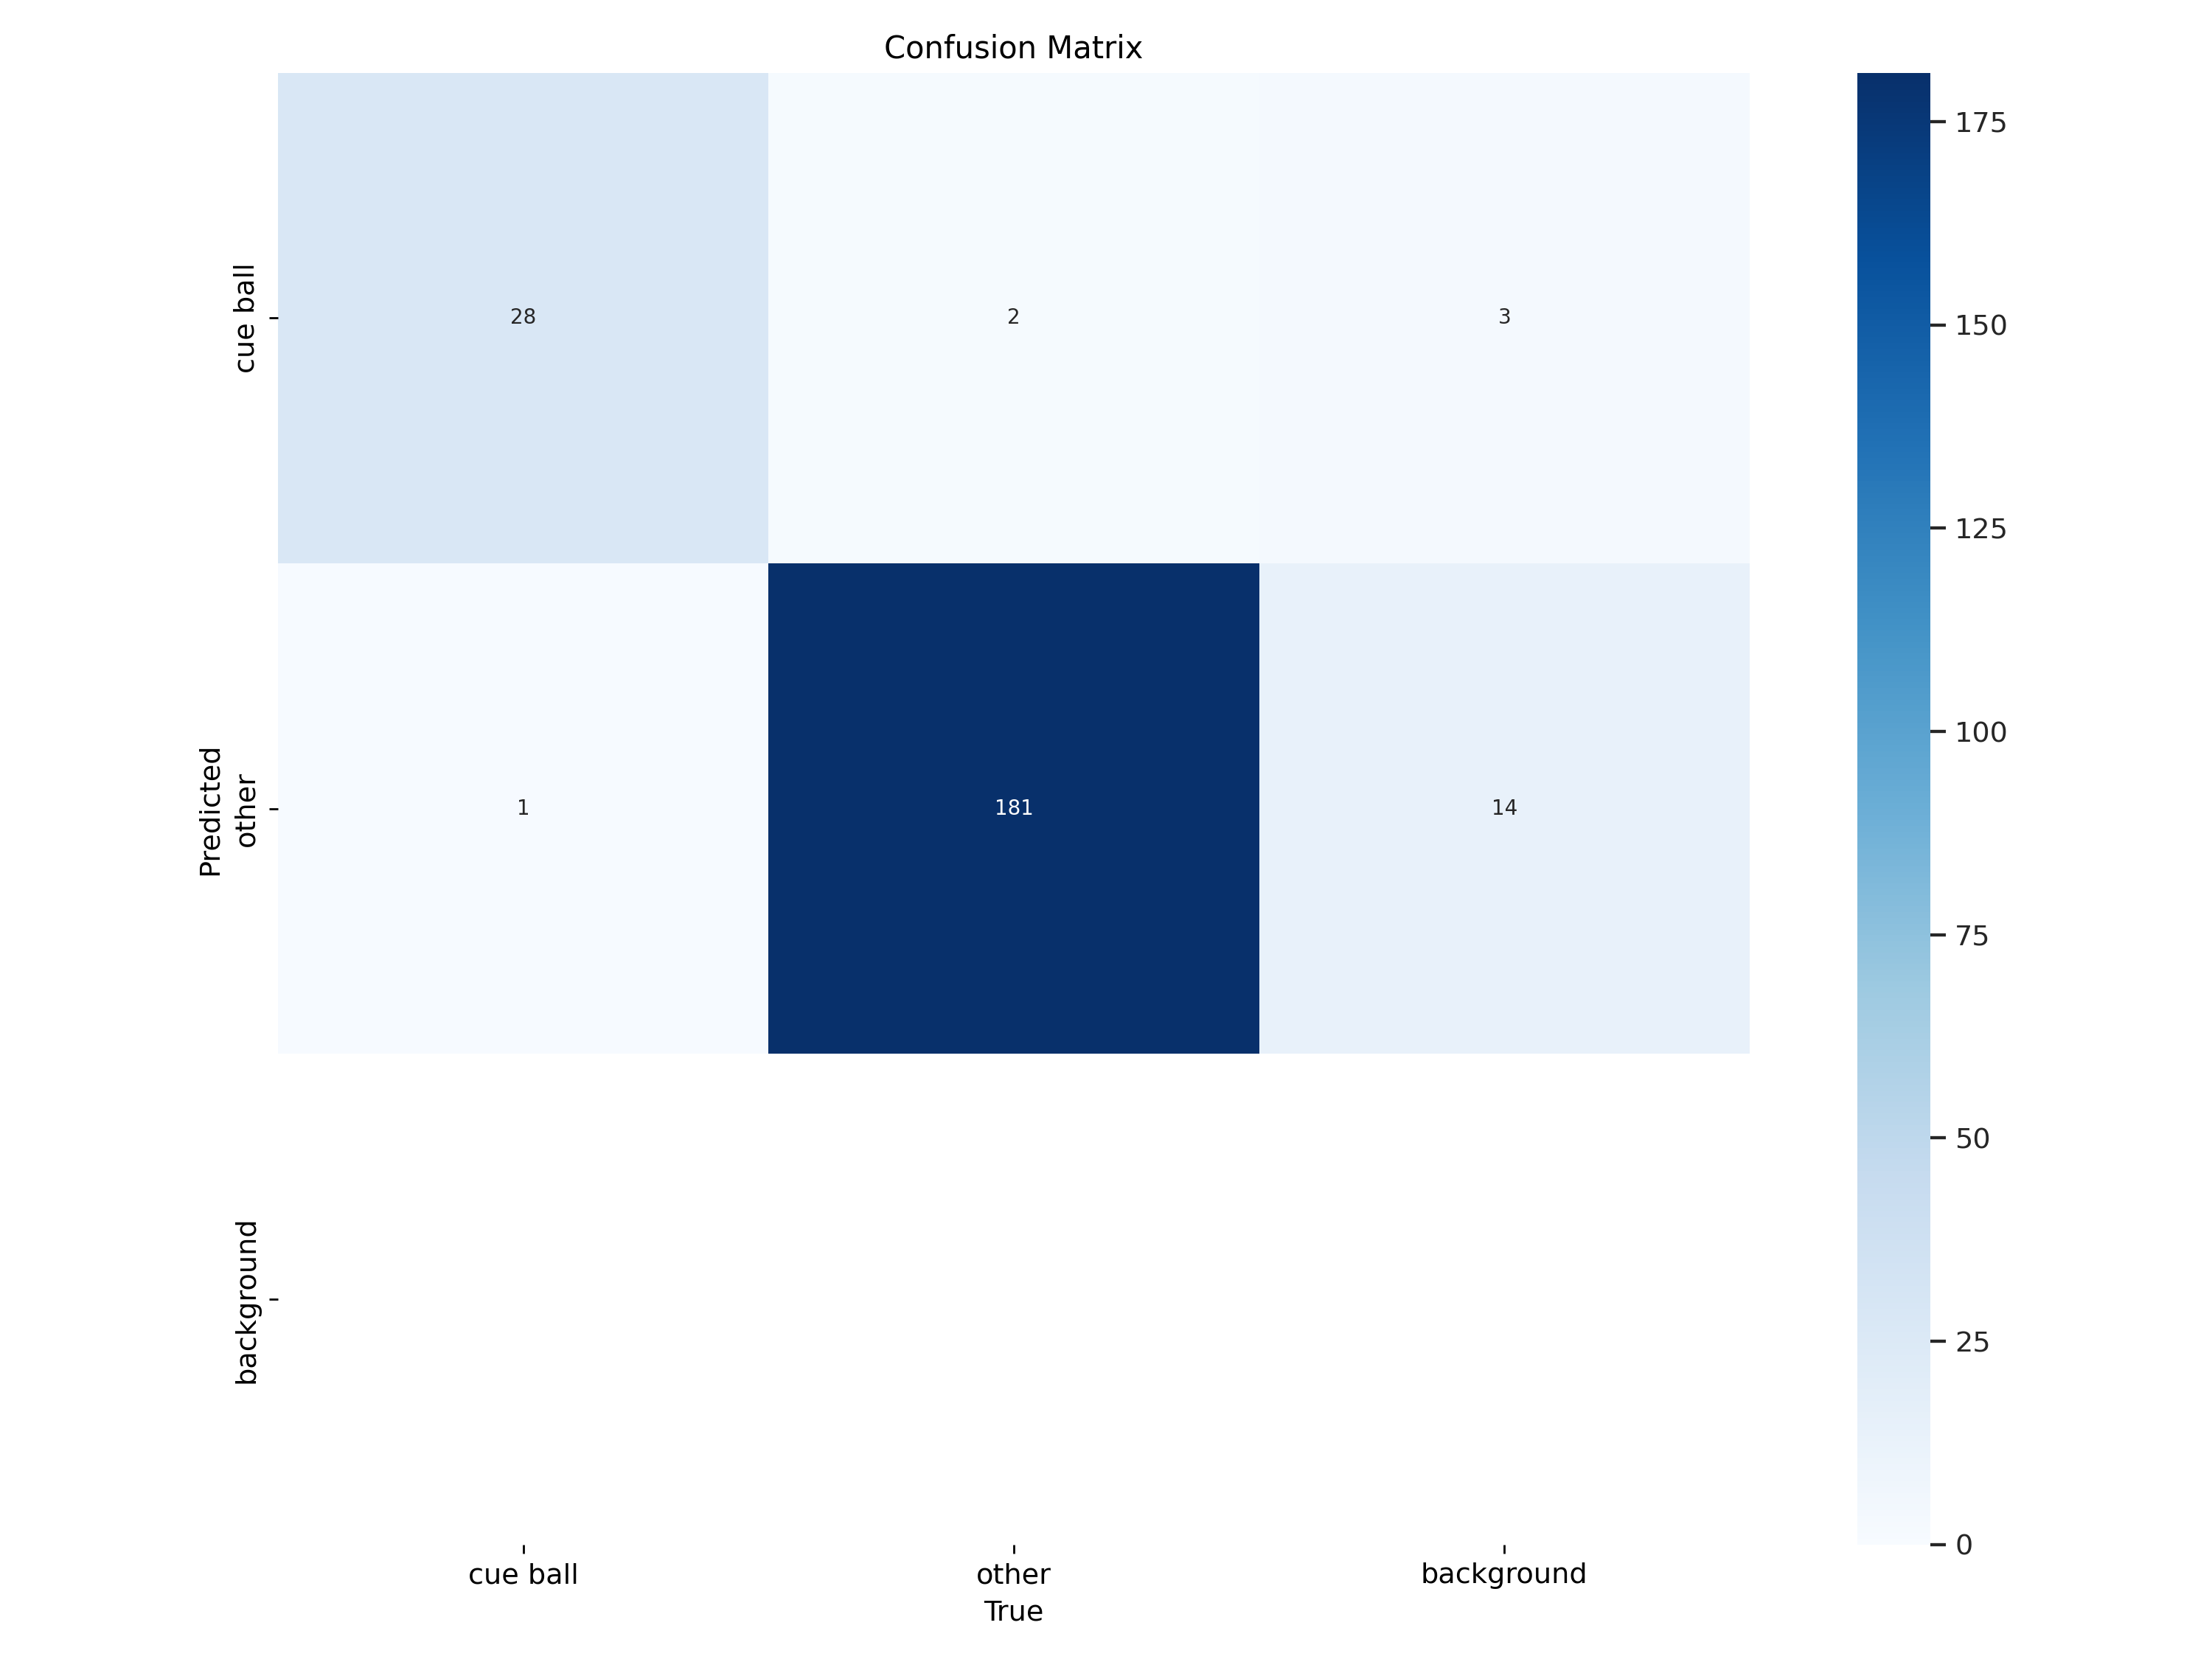

In [17]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

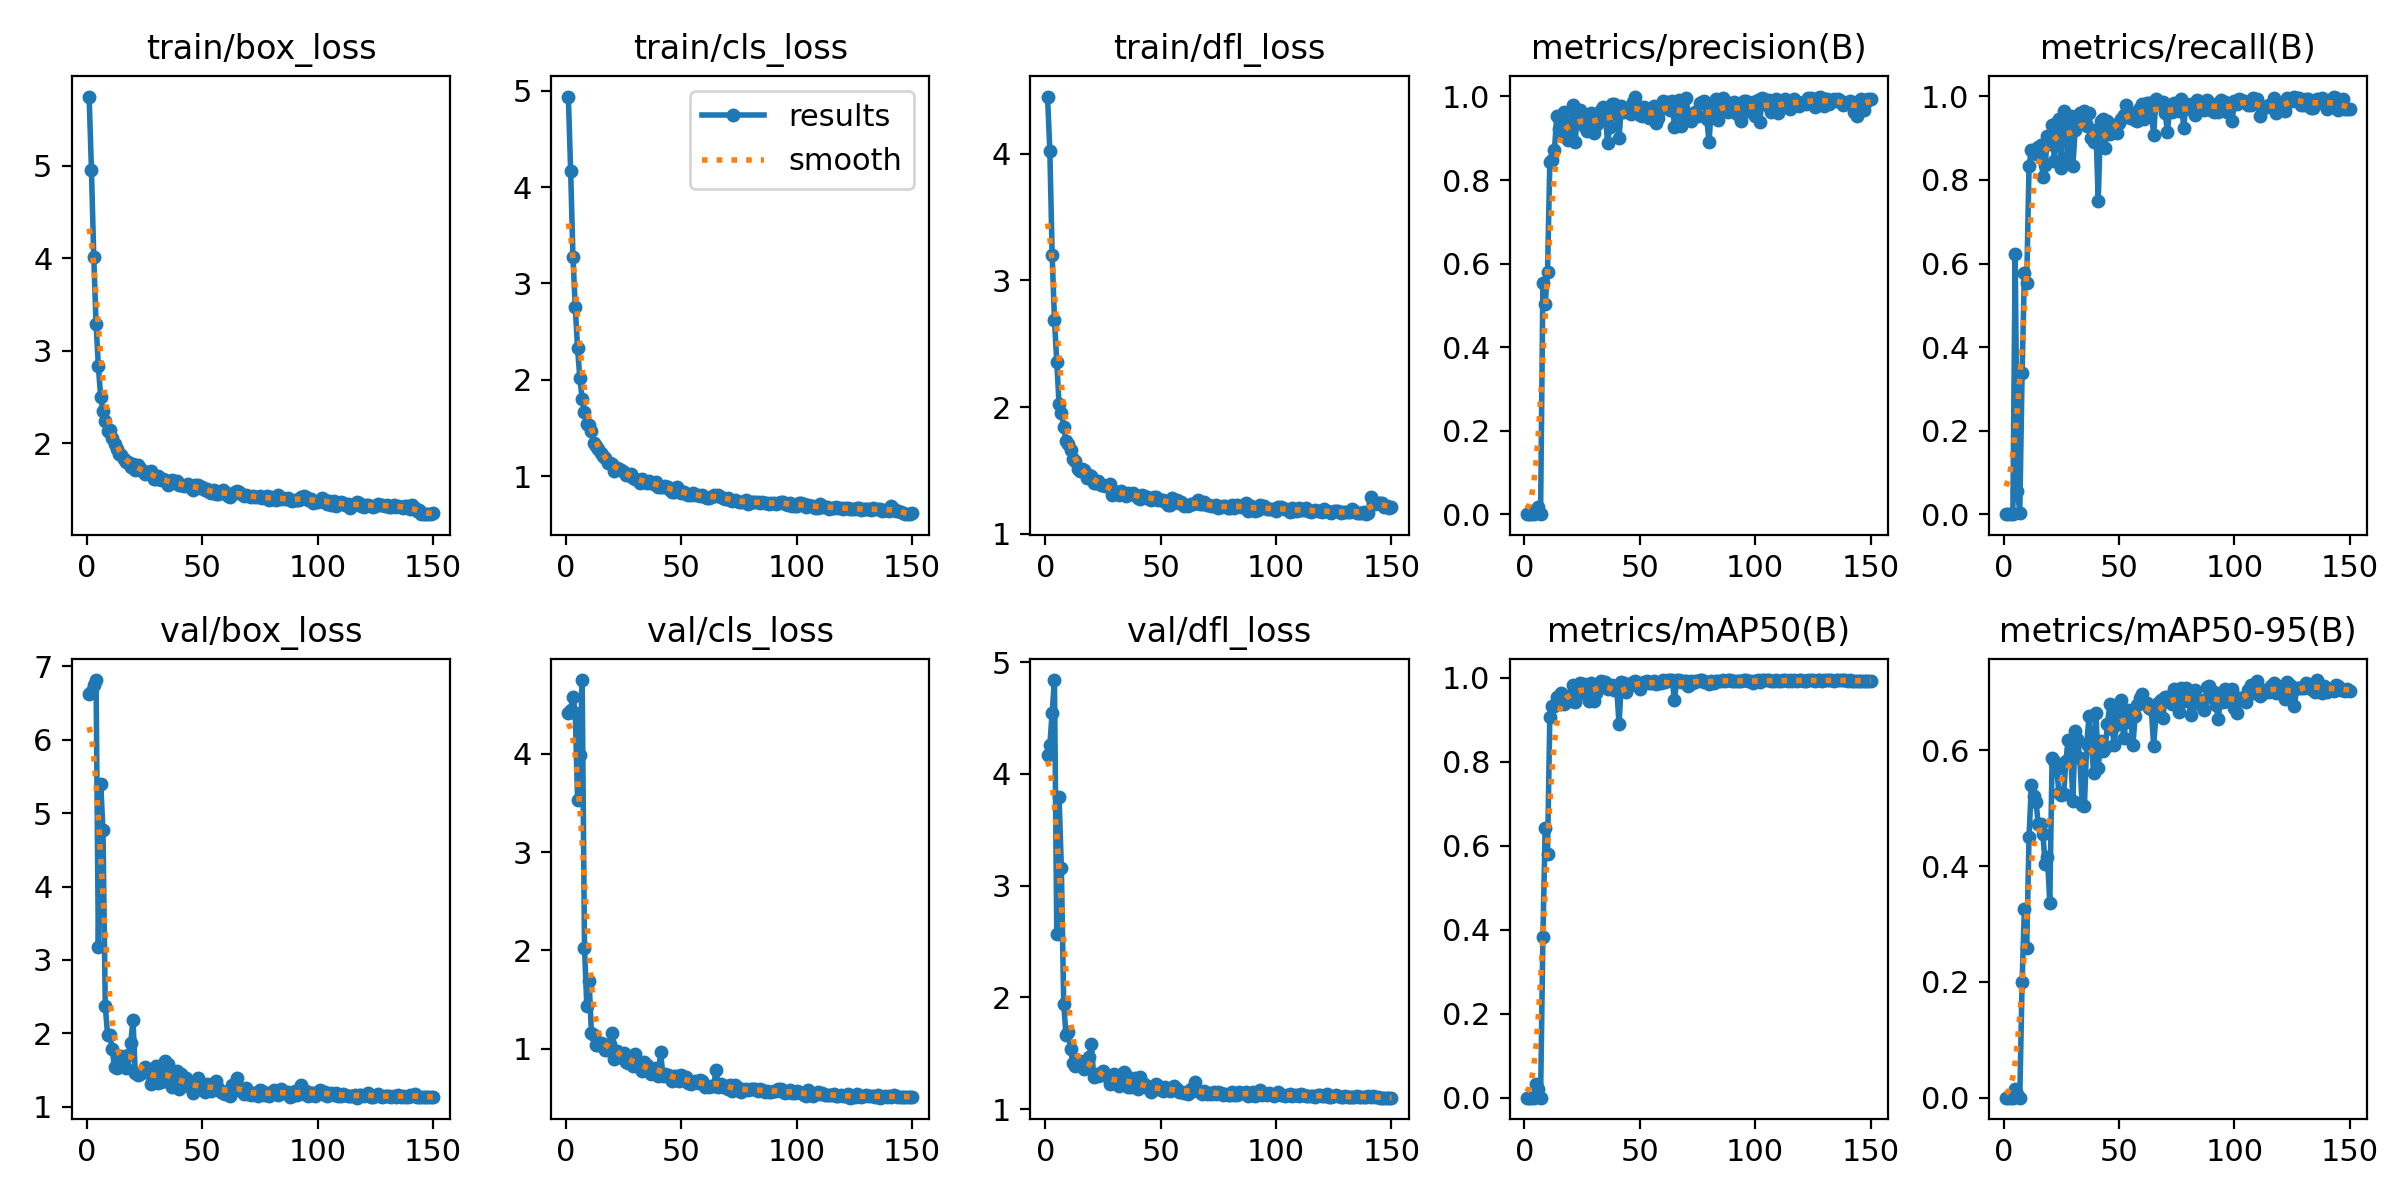

In [18]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [19]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['cue ball', 'other']

In [20]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [21]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.7013446811906727
mAP 50 0.974083958740807
mAP 75 0.878776613655875


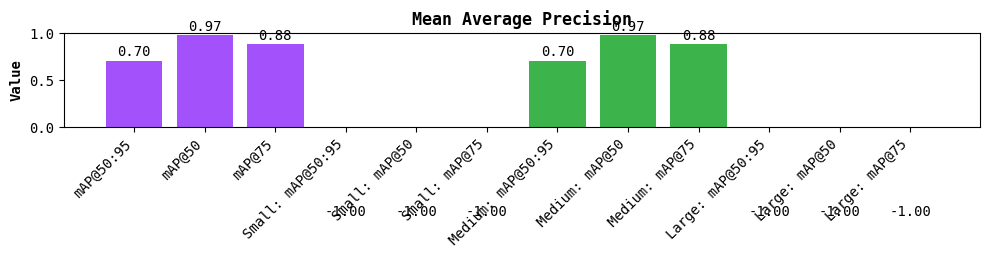

In [22]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [23]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

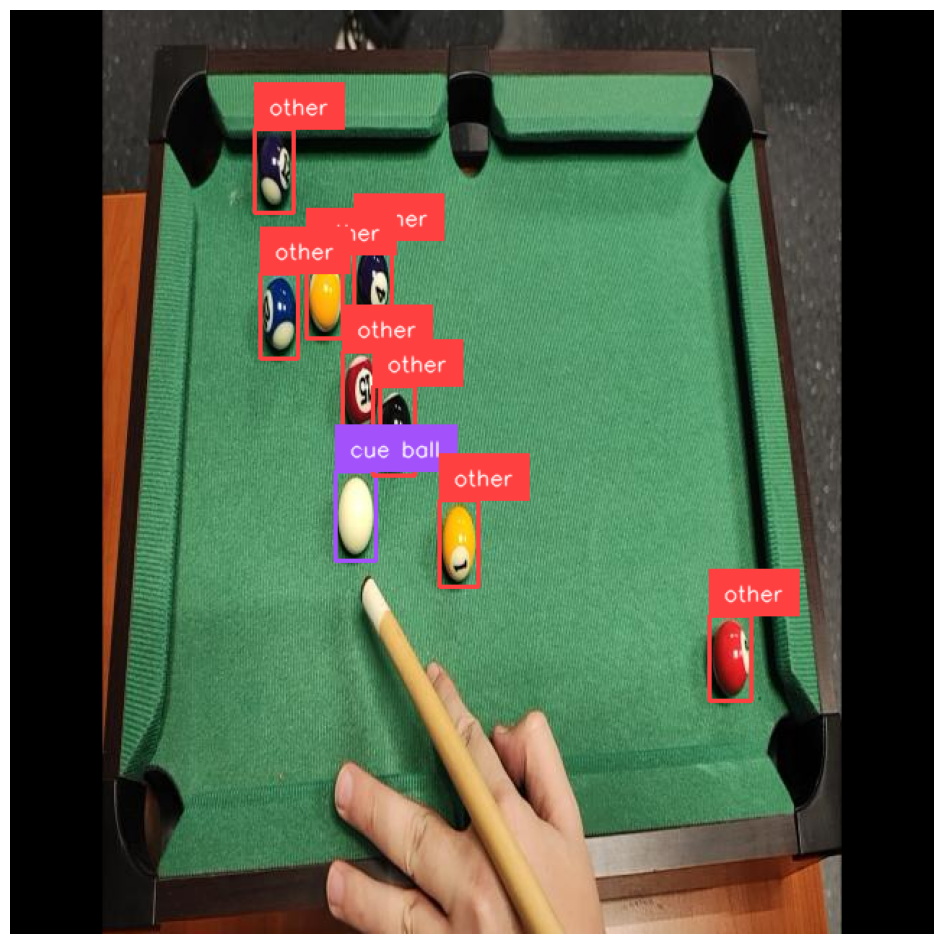

In [24]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

# Deploy your model

In [25]:

project.version(dataset.version).deploy(model_type="yolov12", model_path=f"{HOME}/runs/detect/train/")


!!! ATTENTION !!!
Model must be trained and uploaded using ultralytics from https://github.com/sunsmarterjie/yolov12
or through the Roboflow platform
!!! ATTENTION !!!

View the status of your deployment at: https://app.roboflow.com/thesis-digkz/ball-detection-bzirz/2
Share your model with the world at: https://universe.roboflow.com/thesis-digkz/ball-detection-bzirz/model/2
